In [ ]:
!pip install sqlalchemy graphviz lxml

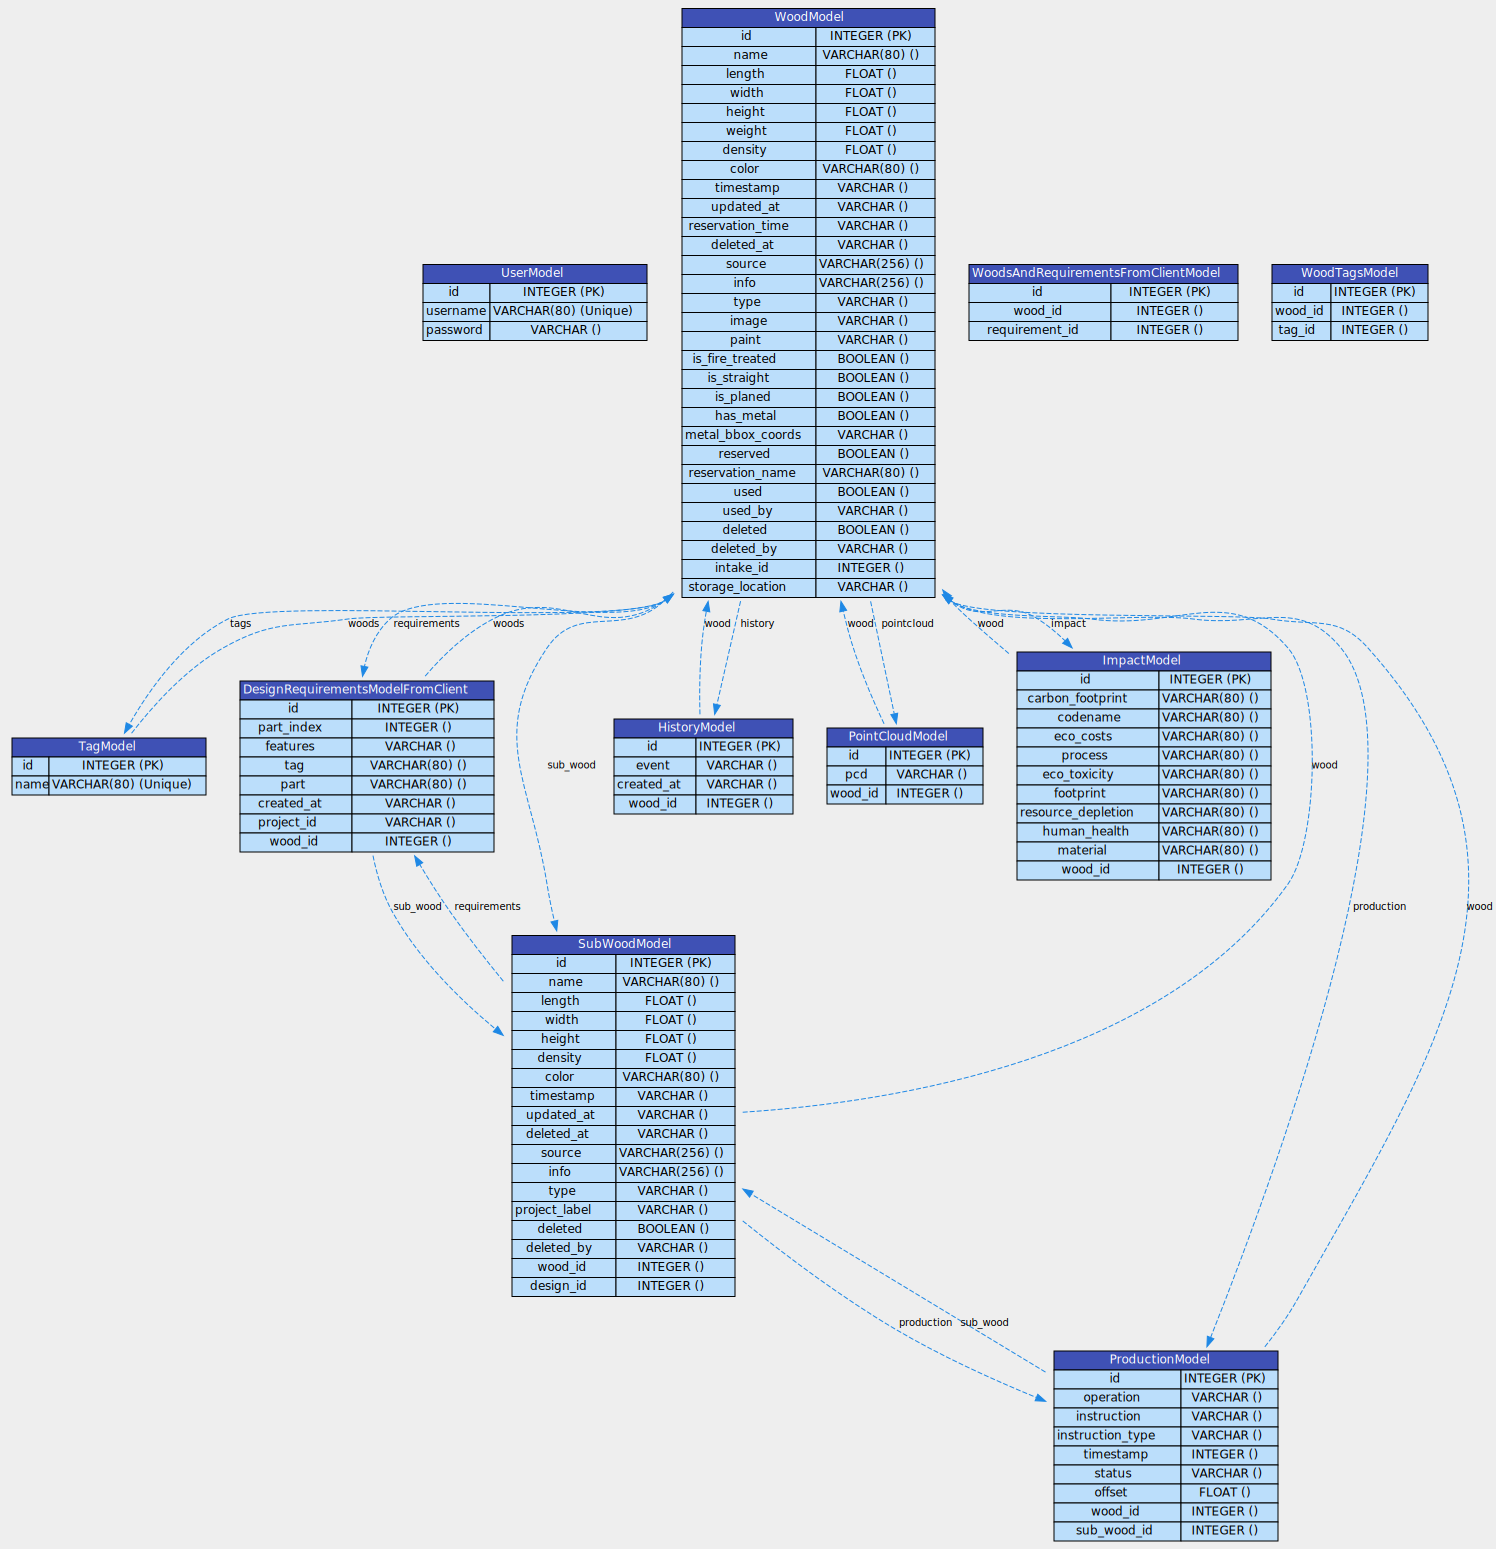

In [4]:
# See Github project here: https://github.com/Dicklesworthstone/sqlalchemy_data_model_visualizer
from datetime import datetime
from typing import Optional
from enum import Enum
from decimal import Decimal
from sqlalchemy.orm import sessionmaker, declarative_base, relationship
from sqlalchemy import Column, String, DateTime, Integer, Numeric, Boolean, Float, JSON, ForeignKey, LargeBinary, Text, UniqueConstraint, CheckConstraint, text as sql_text
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy import inspect
from IPython.core.display import display, SVG
import graphviz
from lxml import etree
import os
import re
Base = declarative_base()

def generate_data_model_diagram(models, output_file='my_data_model_diagram'):
    # Initialize graph with more advanced visual settings
    dot = graphviz.Digraph(comment='Interactive Data Models', format='svg',
                            graph_attr={'bgcolor': '#EEEEEE', 'rankdir': 'TB', 'splines': 'spline'},
                            node_attr={'shape': 'none', 'fontsize': '12', 'fontname': 'Roboto'},
                            edge_attr={'fontsize': '10', 'fontname': 'Roboto'})

    # Iterate through each SQLAlchemy model
    for model in models:
        insp = inspect(model)
        name = insp.class_.__name__

        # Create an HTML-like label for each model as a rich table
        label = f'''<
        <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
        <TR><TD COLSPAN="2" BGCOLOR="#3F51B5"><FONT COLOR="white">{name}</FONT></TD></TR>
        '''

        for column in insp.columns:
            constraints = []
            if column.primary_key:
                constraints.append("PK")
            if column.unique:
                constraints.append("Unique")
            if column.index:
                constraints.append("Index")

            constraint_str = ','.join(constraints)
            color = "#BBDEFB"

            label += f'''<TR>
                         <TD BGCOLOR="{color}">{column.name}</TD>
                         <TD BGCOLOR="{color}">{column.type} ({constraint_str})</TD>
                         </TR>'''

        label += '</TABLE>>'

        # Create the node with added hyperlink to detailed documentation
        dot.node(name, label=label, URL=f"http://{name}_details.html")

        # Add relationships with tooltips and advanced styling
        for rel in insp.relationships:
            target_name = rel.mapper.class_.__name__
            tooltip = f"Relation between {name} and {target_name}"
            dot.edge(name, target_name, label=rel.key, tooltip=tooltip, color="#1E88E5", style="dashed")

    # Render the graph to a file and open it
    dot.render(output_file, view=True)


def add_web_font_and_interactivity(input_svg_file, output_svg_file):
    if not os.path.exists(input_svg_file):
        print(f"Error: {input_svg_file} does not exist.")
        return

    parser = etree.XMLParser(remove_blank_text=True)
    try:
        tree = etree.parse(input_svg_file, parser)
    except etree.XMLSyntaxError as e:
        print(f"Error parsing SVG: {e}")
        return

    root = tree.getroot()

    style_elem = etree.Element("style")
    style_elem.text = '''
    @import url("https://fonts.googleapis.com/css?family=Roboto:400,400i,700,700i");
    '''
    root.insert(0, style_elem)

    for elem in root.iter():
        if 'node' in elem.attrib.get('class', ''):
            elem.attrib['class'] = 'table-hover'
        if 'edge' in elem.attrib.get('class', ''):
            source = elem.attrib.get('source')
            target = elem.attrib.get('target')
            elem.attrib['class'] = f'edge-hover edge-from-{source} edge-to-{target}'

    tree.write(output_svg_file, pretty_print=True, xml_declaration=True, encoding='utf-8')

# ________________________________________________________________


# [Insert the sqlalchemy data model classes here below:]

convention = {
  "ix": "ix_%(column_0_label)s",
  "uq": "uq_%(table_name)s_%(column_0_name)s",
  "ck": "ck_%(table_name)s_%(constraint_name)s",
  "fk": "fk_%(table_name)s_%(column_0_name)s_%(referred_table_name)s",
  "pk": "pk_%(table_name)s"
}


class DesignRequirementsModelFromClient(Base):
    __tablename__ = "requirements"

    id = Column(Integer, primary_key=True)
    part_index = Column(Integer)

    features = Column(String)

    tag = Column(String(80))
    part = Column(String(80))
    created_at = Column(String)
    project_id = Column(String)
    wood_id = Column(Integer)

    woods = relationship(
        "WoodModel", back_populates='requirements', secondary='woods_requirements')
    sub_wood = relationship(
        "SubWoodModel", back_populates='requirements', lazy="dynamic")


class HistoryModel(Base):
    __tablename__ = "history"

    id = Column(Integer, primary_key=True)
    event = Column(String)
    created_at = Column(String)

    wood = relationship("WoodModel", back_populates="history")
    wood_id = Column(Integer, ForeignKey('wood.id'))


class ImpactModel(Base):
    __tablename__ = "idemat"

    id = Column(Integer, primary_key=True)
    carbon_footprint = Column(String(80))
    codename = Column(String(80))
    eco_costs = Column(String(80))
    process = Column(String(80))
    eco_toxicity = Column(String(80))
    footprint = Column(String(80))
    resource_depletion = Column(String(80))
    human_health = Column(String(80))
    material = Column(String(80))

    wood = relationship("WoodModel", back_populates='impact')
    wood_id = Column(Integer, ForeignKey('wood.id'))


class PointCloudModel(Base):
    __tablename__ = 'pointcloud'

    id = Column(Integer, primary_key=True, nullable=False)
    pcd = Column(String)

    wood = relationship("WoodModel", back_populates='pointcloud')
    wood_id = Column(Integer, ForeignKey('wood.id'))



class ProductionModel(Base):
    __tablename__ = "production"
    id = Column(Integer, primary_key=True)
    # milling / sawing
    operation = Column(String)
    # RAPID
    instruction = Column(String)
    # This is a RAPID or mm in length for example
    instruction_type = Column(String)
    timestamp = Column(Integer)
    # pending, done , failed
    status = Column(String)
    # sawing offset
    offset = Column(Float)
    wood = relationship("WoodModel", back_populates='production')
    wood_id = Column(Integer, ForeignKey('wood.id'))
    sub_wood = relationship("SubWoodModel", back_populates='production')
    sub_wood_id = Column(Integer, ForeignKey('sub_wood.id'))


class SubWoodModel(Base):
    __tablename__ = "sub_wood"
    id = Column(Integer, primary_key=True, nullable=False)
    name = Column(String(80))
    # Units in mm
    length = Column(Float(precision=2))
    width = Column(Float(precision=2))
    height = Column(Float(precision=2))
    # Unit in g/cm3
    density = Column(Float(precision=2))
    # (RGB) formatted as string (255, 255, 255)
    color = Column(String(80))
    # Datetime string formatted as YYYY-MM-DD HH:MM:SS
    timestamp = Column(String)
    updated_at = Column(String)
    deleted_at = Column(String)
    source = Column(String(256))
    info = Column(String(256))
    # Wood type such as hardwood or softwood
    type = Column(String)
    project_label = Column(String)
    deleted = Column(Boolean, default=False)
    deleted_by = Column(String)
    wood_id = Column(Integer, ForeignKey('wood.id'))
    wood = relationship("WoodModel", back_populates="sub_wood")
    design_id = Column(Integer, ForeignKey('requirements.id'))
    requirements = relationship(
        "DesignRequirementsModelFromClient", back_populates="sub_wood")

    production = relationship("ProductionModel", back_populates="sub_wood")


class TagModel(Base):
    __tablename__ = "tags"

    id = Column(Integer, primary_key=True)
    name = Column(String(80), nullable=False, unique=True)

    woods = relationship("WoodModel", back_populates='tags', secondary="woods_tags")


class UserModel(Base):
    __tablename__ = 'users'

    id = Column(Integer, primary_key=True, nullable=False)
    username = Column(String(80), unique=True, nullable=False)
    password = Column(String, nullable=False)


class WoodTagsModel(Base):
    __tablename__ = 'woods_tags'

    id = Column(Integer, primary_key=True, nullable=False)
    wood_id = Column(Integer, ForeignKey('wood.id'))
    tag_id = Column(Integer, ForeignKey('tags.id'))

class WoodModel(Base):
    __tablename__ = 'wood'

    id = Column(Integer, primary_key=True, nullable=False)  # 1
    # current_id = Column(Integer)

    # Sub id following the current id 1-1 or 1-2 or ...
    # subsequent_id = Column(String)

    # Name of wood species such as Red oak
    name = Column(String(80))

    # Units in mm
    length = Column(Float(precision=2))
    width = Column(Float(precision=2))
    height = Column(Float(precision=2))

    # Unit in grams
    weight = Column(Float(precision=2))
    # Unit in g/cm3
    density = Column(Float(precision=2))

    # (RGB) formatted as string (255, 255, 255)
    color = Column(String(80))

    # Datetime string formatted as YYYY-MM-DD HH:MM:SS
    timestamp = Column(String)
    updated_at = Column(String)
    reservation_time = Column(String)
    deleted_at = Column(String)

    source = Column(String(256))
    # price = Column(Float(precision=2))
    info = Column(String(256))

    # Wood type such as hardwood or softwood
    type = Column(String)

    # URL to image
    image = Column(String)

    # Only in case of Derako wood
    # project_label = Column(String)
    # project_type = Column(String)

    # In case of waste wood
    paint = Column(String)
    is_fire_treated = Column(Boolean)
    is_straight = Column(Boolean)
    is_planed = Column(Boolean)
    has_metal = Column(Boolean)

    # 8 points as a string following format -> [(x, y, z), ..., (x, y, z)]
    metal_bbox_coords = Column(String)

    # Information regarding the use of material
    reserved = Column(Boolean, default=False)
    reservation_name = Column(String(80))
    used = Column(Boolean, default=False)
    used_by = Column(String)
    deleted = Column(Boolean, default=False)
    deleted_by = Column(String)

    intake_id = Column(Integer)
    storage_location = Column(String)

    # Relationships
    tags = relationship(
        "TagModel", back_populates="woods", secondary="woods_tags")
    requirements = relationship(
        "DesignRequirementsModelFromClient",
        back_populates="woods",
        secondary="woods_requirements"
    )
    production = relationship('ProductionModel')
    history = relationship(
        "HistoryModel", back_populates="wood", lazy="dynamic")
    pointcloud = relationship(
        "PointCloudModel", back_populates="wood", lazy="dynamic")
    impact = relationship(
        "ImpactModel", back_populates="wood", lazy="dynamic")
    sub_wood = relationship(
        "SubWoodModel", back_populates="wood", lazy="dynamic"
    )


class WoodsAndRequirementsFromClientModel(Base):
    __tablename__ = 'woods_requirements'

    id = Column(Integer, primary_key=True, nullable=False)

    wood_id = Column(Integer, ForeignKey('wood.id'))
    requirement_id = Column(Integer, ForeignKey('requirements.id'))


models = [
    UserModel,
    WoodModel,
    TagModel,
    ProductionModel,
    WoodsAndRequirementsFromClientModel,
    WoodTagsModel,
    SubWoodModel,
    DesignRequirementsModelFromClient,
    ImpactModel,
    PointCloudModel,
    HistoryModel,
]

output_file_name = 'my_data_model_diagram'
# Generate the diagram and add interactivity
generate_data_model_diagram(models, output_file_name)
add_web_font_and_interactivity('my_data_model_diagram.svg', 'my_interactive_data_model_diagram.svg')

# Display the SVG file
display(SVG(filename='my_interactive_data_model_diagram.svg'))